In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import hashlib
from collections import defaultdict

USE_GPU = True
dtype = torch.float32 # We will be using float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [ ]:
# Define the path to the dataset
dataset_path = "../../sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data"

# Define the batch size
batch_size = 64

# Load the dataset without transformations
dataset = datasets.ImageFolder(root=dataset_path)

# Get the total number of samples
total_samples = len(dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Print the sizes of each split
print(f"Total samples: {total_samples}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Total samples: 55500
Training set size: 38850
Validation set size: 11100
Test set size: 5550


In [3]:
# Iterate through a few samples to get their original dimensions
for idx, (image, label) in enumerate(dataset):
    if idx >= 10:  # Limit to 10 samples
        break
    width, height = image.size  # PIL.Image.size returns (width, height)
    print(f"Image {idx + 1}: Width={width}, Height={height}")

Image 1: Width=50, Height=50
Image 2: Width=50, Height=50
Image 3: Width=50, Height=50
Image 4: Width=50, Height=50
Image 5: Width=50, Height=50
Image 6: Width=50, Height=50
Image 7: Width=50, Height=50
Image 8: Width=50, Height=50
Image 9: Width=50, Height=50
Image 10: Width=50, Height=50


In [4]:
# Define a transform without normalization
transform = transforms.Compose([
    transforms.ToTensor()        # Convert images to PyTorch tensors
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create a DataLoader to iterate through the dataset
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Compute mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
total_pixels = 0

# The dimensions in images.size() represent:

# 0 (Batch Dimension): The number of images in a batch.
# 1 (Channel Dimension): The color channels (e.g., RGB: 3 channels).
# 2 (Height): The height of the image.
# 3 (Width): The width of the image.

print("Computing mean and std...")

# Iterate over the DataLoader to process the images in batches
for images, _ in tqdm(loader):
    # Calculate the total number of pixels in the batch for all channels
    # images.size(0) -> Number of images in the batch (batch size)
    # images.size(2) -> Height of each image
    # images.size(3) -> Width of each image
    # Multiply these together to get the total pixels per image across all channels
    total_pixels += images.size(0) * images.size(2) * images.size(3)

    # Accumulate the sum of pixel values for each channel (R, G, B)
    # dim=[0, 2, 3] -> Sum over batch, height, and width dimensions
    # Result is a tensor with the sum for each channel
    mean += images.sum(dim=[0, 2, 3])

    # Accumulate the sum of squared pixel values for each channel
    # This is used later to calculate the standard deviation
    std += (images ** 2).sum(dim=[0, 2, 3])

# Finalize mean by dividing the accumulated sum by the total number of pixels
mean /= total_pixels

# Finalize std by first calculating variance (sum of squared differences / total pixels)
# Then take the square root to get the standard deviation
std = torch.sqrt(std / total_pixels)

# Print the computed mean and std for all channels
print(f"Computed Mean: {mean.tolist()}")
print(f"Computed Std: {std.tolist()}")

Computing mean and std...


  1%|          | 8/868 [00:00<00:33, 25.43it/s]

100%|██████████| 868/868 [00:26<00:00, 32.23it/s]

Computed Mean: [0.5273298025131226, 0.4507707953453064, 0.4120909869670868]
Computed Std: [0.5632718205451965, 0.5085217952728271, 0.48751917481422424]


In [5]:
# Already computed mean and std
computed_mean = [0.5273298025131226, 0.4507707953453064, 0.4120909869670868]
computed_std = [0.5632718205451965, 0.5085217952728271, 0.48751917481422424]

# Define the transformations
transform = transforms.Compose([
    #transforms.Resize((X, Y)),  # Resize images to X,Y if necessary
    transforms.ToTensor(),       # Convert images to PyTorch tensors
    transforms.Normalize(mean=computed_mean, std=computed_std)  # Normalize
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = dataset.classes
print("Class names:", class_names)

# Example of iterating through the train DataLoader
for images, labels in train_loader:
    print("Train Batch - Images shape:", images.shape)
    print("Train Batch - Labels shape:", labels.shape)
    break

# Print dataset sizes for verification
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

len_train_loader = len(train_loader)
len_val_loader = len(val_loader)
len_test_loader = len(test_loader)

# Print DataLoader sizes for verification
print(f"Train DataLoader size: {len(train_loader)}")
print(f"Validation DataLoader size: {len(val_loader)}")
print(f"Test DataLoader size: {len(test_loader)}")

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']
Train Batch - Images shape: torch.Size([64, 3, 50, 50])
Train Batch - Labels shape: torch.Size([64])
Train set size: 38850
Validation set size: 11100
Test set size: 5550
Train DataLoader size: 608
Validation DataLoader size: 174
Test DataLoader size: 87


In [10]:
def get_class_distribution(loader, dataset_classes):
    """
    Computes the distribution of classes in a DataLoader.

    Args:
    - loader: DataLoader to inspect
    - dataset_classes: List of class names for the dataset

    Returns:
    - class_counts: Dictionary with class names as keys and counts as values
    """
    class_counts = Counter()
    for inputs, labels in loader:
        class_counts.update(labels.numpy())

    # Convert to a dictionary with class names
    class_distribution = {dataset_classes[i]: class_counts[i] for i in range(len(dataset_classes))}
    return class_distribution

def display_class_distribution(distribution, title="Class Distribution"):
    """
    Displays the class distribution as a bar chart.

    Args:
    - distribution: Dictionary with class names as keys and counts as values
    - title: Title for the bar chart
    """

    class_names = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Total DataLoader Distribution:
  0: 1500
  1: 1500
  2: 1500
  3: 1500
  4: 1500
  5: 1500
  6: 1500
  7: 1500
  8: 1500
  9: 1500
  A: 1500
  B: 1500
  C: 1500
  D: 1500
  E: 1500
  F: 1500
  G: 1500
  H: 1500
  I: 1500
  J: 1500
  K: 1500
  L: 1500
  M: 1500
  N: 1500
  O: 1500
  P: 1500
  Q: 1500
  R: 1500
  S: 1500
  T: 1500
  U: 1500
  V: 1500
  W: 1500
  X: 1500
  Y: 1500
  Z: 1500
  _: 1500


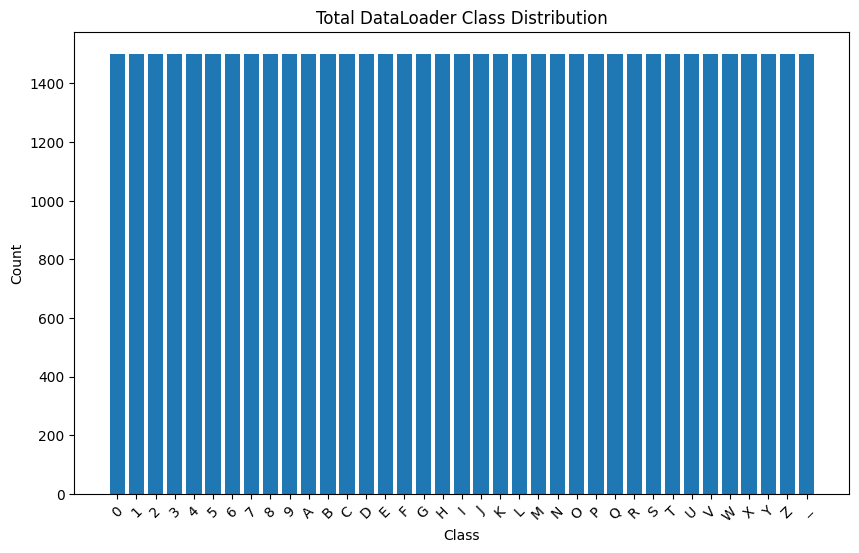

Train DataLoader Distribution:
  0: 1076
  1: 1052
  2: 1046
  3: 1044
  4: 1072
  5: 1041
  6: 1038
  7: 1070
  8: 1051
  9: 1011
  A: 1052
  B: 1062
  C: 1057
  D: 1057
  E: 1060
  F: 1066
  G: 1057
  H: 1053
  I: 1062
  J: 1054
  K: 1052
  L: 1044
  M: 1062
  N: 1077
  O: 1042
  P: 1054
  Q: 1055
  R: 1035
  S: 1033
  T: 1035
  U: 1024
  V: 1042
  W: 1064
  X: 1027
  Y: 1038
  Z: 1035
  _: 1050


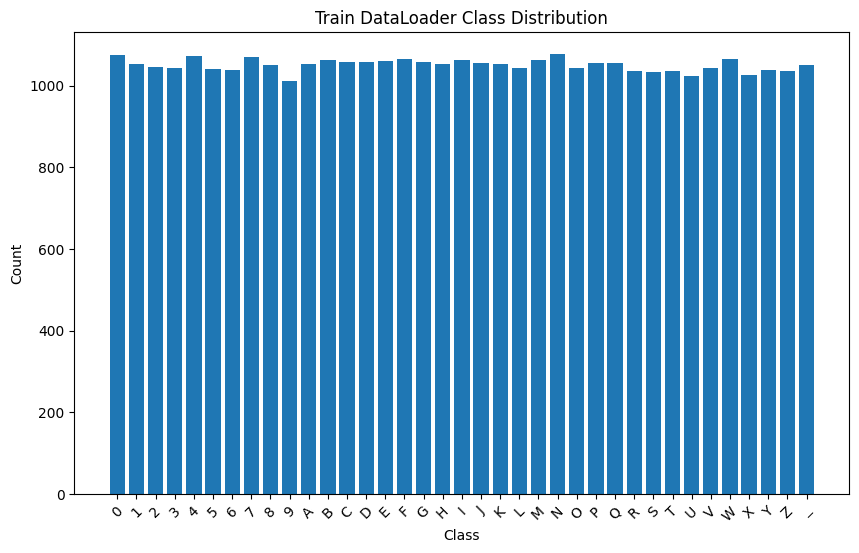

Validation DataLoader Distribution:
  0: 267
  1: 325
  2: 316
  3: 300
  4: 283
  5: 300
  6: 297
  7: 288
  8: 300
  9: 328
  A: 284
  B: 284
  C: 286
  D: 302
  E: 295
  F: 290
  G: 314
  H: 308
  I: 311
  J: 288
  K: 307
  L: 294
  M: 267
  N: 289
  O: 288
  P: 286
  Q: 304
  R: 300
  S: 314
  T: 313
  U: 301
  V: 315
  W: 304
  X: 311
  Y: 310
  Z: 319
  _: 312


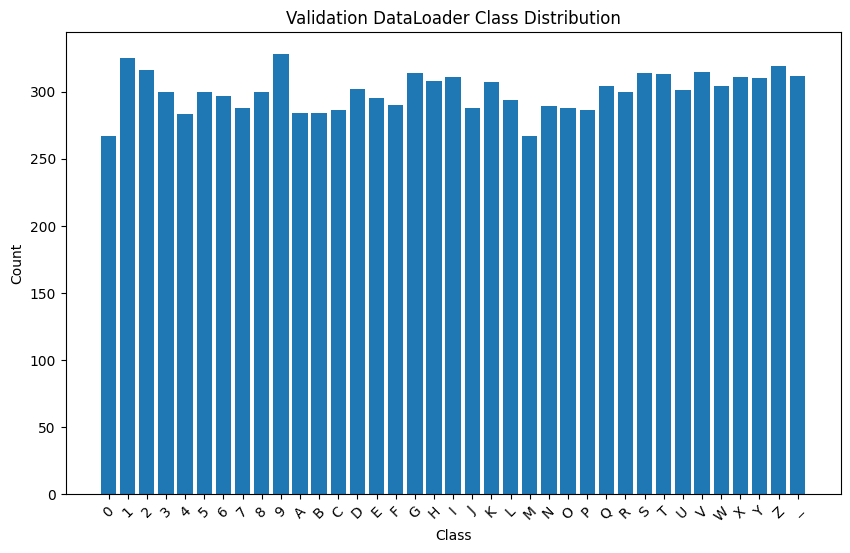

Test DataLoader Distribution:
  0: 157
  1: 123
  2: 138
  3: 156
  4: 145
  5: 159
  6: 165
  7: 142
  8: 149
  9: 161
  A: 164
  B: 154
  C: 157
  D: 141
  E: 145
  F: 144
  G: 129
  H: 139
  I: 127
  J: 158
  K: 141
  L: 162
  M: 171
  N: 134
  O: 170
  P: 160
  Q: 141
  R: 165
  S: 153
  T: 152
  U: 175
  V: 143
  W: 132
  X: 162
  Y: 152
  Z: 146
  _: 138


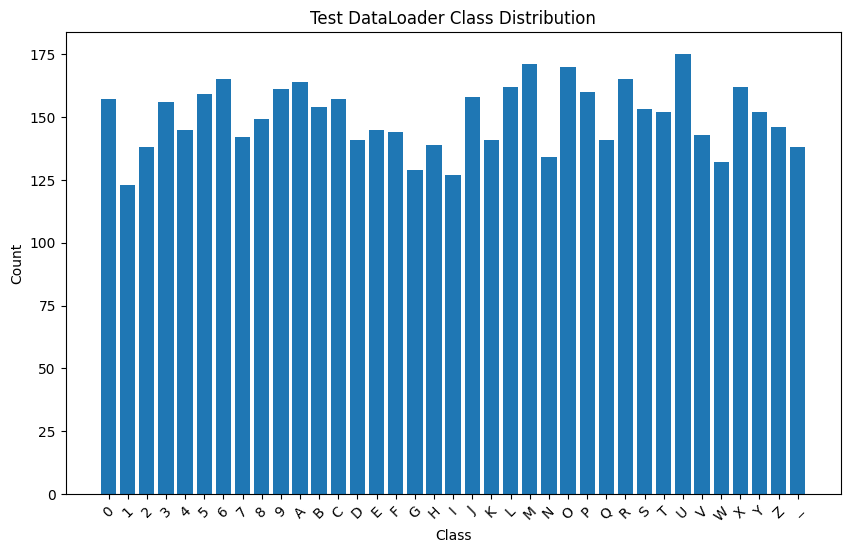

In [11]:
# Compute and display class distribution for each DataLoader
for loader, name in [(loader, "Total"),(train_loader, "Train"), (val_loader, "Validation"), (test_loader, "Test")]:
    distribution = get_class_distribution(loader, class_names)
    print(f"{name} DataLoader Distribution:")
    for cls, count in distribution.items():
        print(f"  {cls}: {count}")
    display_class_distribution(distribution, title=f"{name} DataLoader Class Distribution")

/tmp/ipykernel_681472/4129431349.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = img * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)  # De-normalize


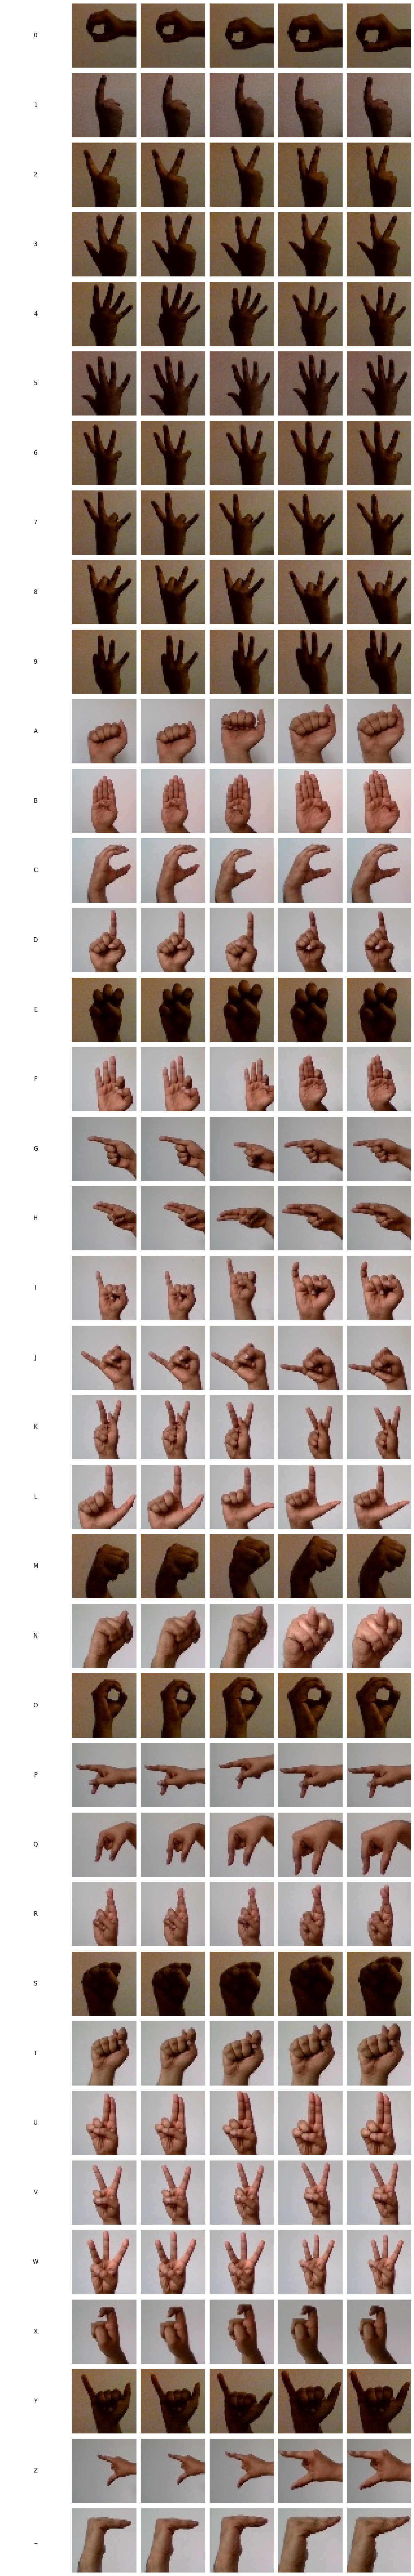

In [12]:
def visualize_images_per_class(dataset, dataset_classes, num_images=5):
    """
    Visualizes a few images from each class in the dataset.

    Args:
    - dataset: The dataset to sample from.
    - dataset_classes: List of class names for the dataset.
    - num_images: Number of images to display per class.
    """
    class_to_indices = {cls: [] for cls in range(len(dataset_classes))}

    # Group indices by class
    for idx, (_, label) in enumerate(dataset):
        if len(class_to_indices[label]) < num_images:
            class_to_indices[label].append(idx)
        if all(len(indices) == num_images for indices in class_to_indices.values()):
            break

    # Plot the images
    fig, axes = plt.subplots(len(dataset_classes), num_images + 1, figsize=((num_images + 1) * 2, len(dataset_classes) * 2))
    for cls_idx, cls_name in enumerate(dataset_classes):
        indices = class_to_indices[cls_idx]

        # Add class name to the first column of each row
        axes[cls_idx, 0].text(0.5, 0.5, cls_name, fontsize=12, ha='center', va='center', transform=axes[cls_idx, 0].transAxes)
        axes[cls_idx, 0].axis("off")

        for img_idx, data_idx in enumerate(indices):
            img, label = dataset[data_idx]
            ax = axes[cls_idx, img_idx + 1]  # Shift by 1 for the class name column
            img = img.permute(1, 2, 0)  # Convert CHW to HWC
            img = img * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)  # De-normalize
            img = torch.clamp(img, 0, 1)  # Clip values to valid range
            ax.imshow(img)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize 5 images per class for train set
visualize_images_per_class(dataset, class_names, num_images=5)

In [7]:
# Function to compute hash of a tensor
def compute_hash(image_tensor):
    # Convert tensor to bytes
    image_bytes = image_tensor.numpy().tobytes()
    # Compute MD5 hash
    return hashlib.md5(image_bytes).hexdigest()

# Detect duplicates
hashes = {}
duplicates = []

for batch in tqdm(loader, desc="Processing batches"):
    images, labels = batch
    for idx, image in enumerate(images):
        image_hash = compute_hash(image)
        if image_hash in hashes:
            duplicates.append((hashes[image_hash], dataset.samples[idx][0]))
        else:
            hashes[image_hash] = dataset.samples[idx][0]

print(f"Found {len(duplicates)} duplicate images.")

Processing batches: 100%|██████████| 868/868 [00:23<00:00, 36.55it/s]

Found 12165 duplicate images.


Calculating per-image statistics:   0%|          | 0/868 [00:00<?, ?it/s]

Calculating per-image statistics: 100%|██████████| 868/868 [00:22<00:00, 38.99it/s]


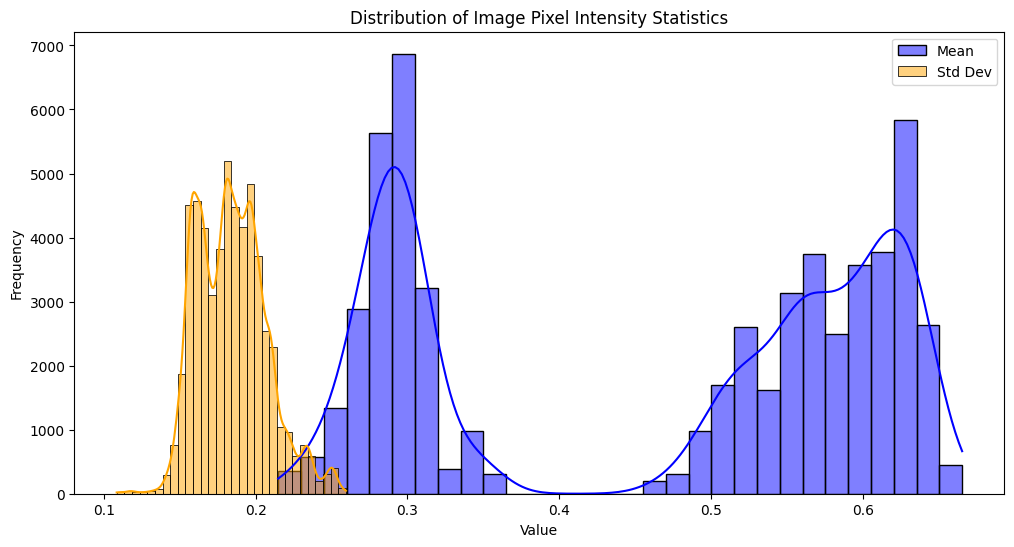

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store per-image mean and std deviation
image_means = []
image_stds = []

# Iterate over DataLoader
for images, _ in tqdm(loader, desc="Calculating per-image statistics"):
    # Compute mean and std for each image in the batch
    for img in images:
        img = img.view(-1)  # Flatten the image
        image_means.append(img.mean().item())
        image_stds.append(img.std().item())

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(image_means, bins=30, kde=True, color='blue', label='Mean')
sns.histplot(image_stds, bins=30, kde=True, color='orange', label='Std Dev')
plt.legend()
plt.title('Distribution of Image Pixel Intensity Statistics')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()